# 🤖 Intro to Machine Learning Week 4
Ellie Zhou, August 2025

## What you'll learn in this notebook
- How to work with the CIFAR-10 dataset
- How to build & train a custom CNN
- How to work with data transforms
- How to do data augmentation

**Before you get started, change the runtime type to a gpu

#Section 1 - Imports

In [1]:
# Import PyTorch libraries for deep learning
import torch                    # Main PyTorch library
import torch.nn as nn          # Neural network modules (layers, loss functions)
import torch.optim as optim    # Optimization algorithms (Adam, SGD, etc.)
import torch.nn.functional as F # Functional interface (activation functions, etc.)
from torch.utils.data import DataLoader  # For loading data in batches

# Import torchvision for computer vision tasks
import torchvision             # Computer vision library built on PyTorch
from torchvision import datasets, transforms  # Datasets and image transformations
from PIL import Image          # Python Imaging Library for image processing

# Import other useful libraries
import numpy as np             # Numerical computing
import matplotlib.pyplot as plt # Plotting and visualization
import seaborn as sns          # Statistical data visualization
from sklearn.metrics import classification_report, confusion_matrix  # Evaluation metrics
import time                    # For timing training duration

# Set up device (GPU if available, otherwise CPU)
# GPU training is much faster than CPU for deep learning
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
# This ensures we get the same results every time we run the code
torch.manual_seed(42)          # PyTorch random seed
np.random.seed(42)             # NumPy random seed

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.8.0+cu126


#Section 2 - Data Transforms and Loading

In [2]:
# ==============================================================================
# SECTION 2: DATA TRANSFORMS AND LOADING
# ==============================================================================

print("Setting up data transforms...")

# TRAINING TRANSFORMS - Applied to training data
# Data augmentation helps prevent overfitting and makes the model more robust
train_transform = transforms.Compose([  # Compose multiple transforms together

    # Data Augmentation Techniques:
    transforms.RandomRotation(15),       # Randomly rotate images by up to 15 degrees
                                        # This helps the model recognize objects at different angles

    transforms.RandomHorizontalFlip(0.5), # Flip images horizontally with 50% probability
                                         # Objects can appear facing left or right in real life

    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
                                                           # This simulates different lighting conditions

    transforms.RandomCrop(32, padding=4), # Randomly crop 32x32 pixels with 4-pixel padding
                                         # This helps the model focus on different parts of objects

    # Standard Preprocessing:
    transforms.ToTensor(),               # Convert PIL image to PyTorch tensor (0-1 range)
                                        # Changes format from (H,W,C) to (C,H,W)

    transforms.Normalize(                # Normalize pixel values using ImageNet statistics
        mean=[0.485, 0.456, 0.406],     # Mean values for RGB channels
        std=[0.229, 0.224, 0.225]       # Standard deviation values for RGB channels
    )                                   # This helps the neural network train more efficiently
])

# TEST TRANSFORMS - Applied to test/validation data
# No augmentation here because we want consistent, reproducible results
test_transform = transforms.Compose([
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize(                # Same normalization as training
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✓ Data transforms configured")

# LOAD CIFAR-10 DATASET
print("Loading CIFAR-10 dataset...")

# CIFAR-10 contains 60,000 32x32 color images in 10 classes:
# airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
# 50,000 training images + 10,000 test images

# Load training data with augmentation transforms
train_dataset = datasets.CIFAR10(
    root='./data',              # Directory to store/load data
    train=True,                 # Load training set
    download=True,              # Download if not already present
    transform=train_transform   # Apply training transforms
)

# Load test data with test transforms (no augmentation)
test_dataset = datasets.CIFAR10(
    root='./data',              # Same directory
    train=False,                # Load test set
    download=True,              # Download if needed
    transform=test_transform    # Apply test transforms
)

# Define class names for easy interpretation of results
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Test samples: {len(test_dataset)}")
print(f"✓ Number of classes: {len(class_names)}")

# CREATE DATA LOADERS
# Data loaders handle batching, shuffling, and parallel loading
batch_size = 64                # Process 64 images at once (adjust based on GPU memory)
num_workers = 2                # Number of CPU processes for data loading

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,     # Size of each batch
    shuffle=True,              # Randomly shuffle data each epoch (prevents overfitting)
    num_workers=num_workers    # Parallel data loading for speed
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,     # Same batch size for consistency
    shuffle=False,             # Don't shuffle test data (we want reproducible results)
    num_workers=num_workers
)
print(f"✓ Data loaders created with batch size: {batch_size}")

Setting up data transforms...
✓ Data transforms configured
Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:49<00:00, 3.44MB/s]


✓ Training samples: 50000
✓ Test samples: 10000
✓ Number of classes: 10


#Section 3 - Visualize Data and Augmented Data

Creating data visualizations...
Showing sample CIFAR-10 images...


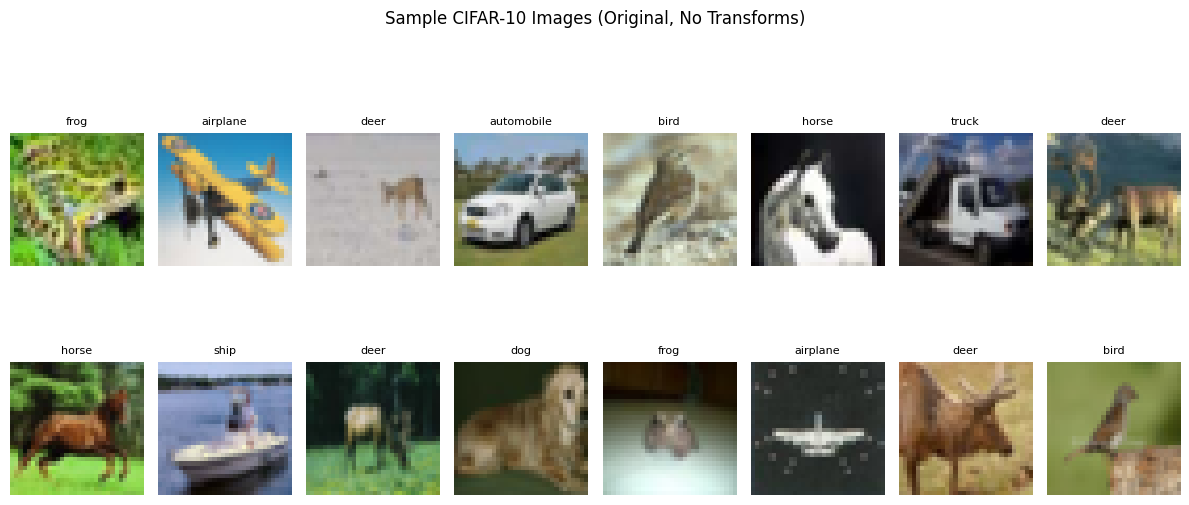

Demonstrating data augmentation effects...


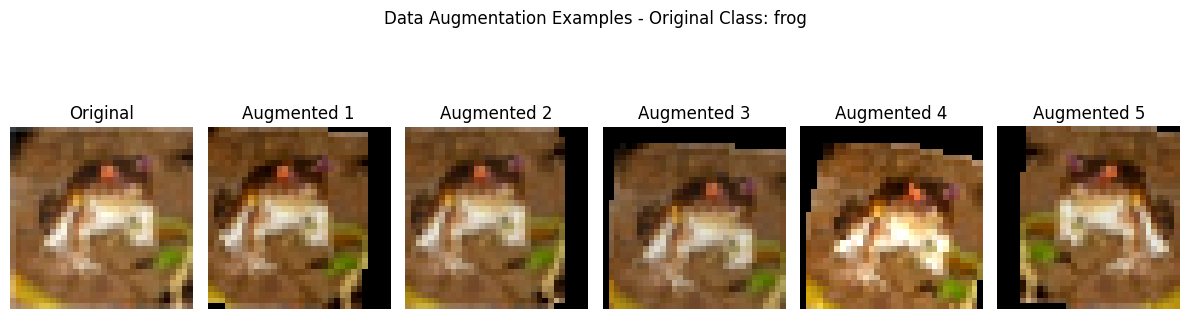

In [3]:
# ==============================================================================
# SECTION 3: VISUALIZE DATA AND AUGMENTATION
# ==============================================================================

print("Creating data visualizations...")

def show_sample_images():
    """Display sample images from CIFAR-10 to understand our data"""
    print("Showing sample CIFAR-10 images...")

    # Load original images without any transforms to see them clearly
    original_dataset = datasets.CIFAR10(root='./data', train=True,
                                       transform=transforms.ToTensor())
    original_loader = DataLoader(original_dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(original_loader))  # Get one batch

    plt.figure(figsize=(12, 6))
    for i in range(16):
        plt.subplot(2, 8, i + 1)        # Create 2x8 grid of subplots

        # Convert tensor to displayable format
        # PyTorch tensors are (C,H,W), matplotlib expects (H,W,C)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)

        # Show class name as title
        plt.title(f'{class_names[labels[i]]}', fontsize=8)
        plt.axis('off')                 # Remove axis for cleaner look

    plt.suptitle('Sample CIFAR-10 Images (Original, No Transforms)')
    plt.tight_layout()
    plt.show()

def show_augmentation():
    """Show how data augmentation transforms the same image differently"""
    print("Demonstrating data augmentation effects...")

    # Get one original image
    original_dataset = datasets.CIFAR10(root='./data', train=True,
                                       transform=transforms.ToTensor())
    original_img, label = original_dataset[0]  # First image in dataset

    plt.figure(figsize=(12, 4))

    # Show original image
    plt.subplot(1, 6, 1)
    plt.imshow(original_img.permute(1, 2, 0).numpy())
    plt.title('Original')
    plt.axis('off')

    # Show 5 different augmented versions of the same image
    for i in range(5):
        plt.subplot(1, 6, i + 2)

        # Convert tensor back to PIL Image for transforms
        pil_img = transforms.ToPILImage()(original_img)

        # Apply training transforms (which include augmentation)
        augmented = train_transform(pil_img)

        # Denormalize for display (reverse the normalization)
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        denorm = augmented * std.view(3, 1, 1) + mean.view(3, 1, 1)
        denorm = torch.clamp(denorm, 0, 1)  # Ensure values stay in [0,1] range

        plt.imshow(denorm.permute(1, 2, 0).numpy())
        plt.title(f'Augmented {i+1}')
        plt.axis('off')

    plt.suptitle(f'Data Augmentation Examples - Original Class: {class_names[label]}')
    plt.tight_layout()
    plt.show()

# Display the visualizations
show_sample_images()
show_augmentation()

#Section 4 - Defining CNN Model Architecture

In [4]:
print("Defining CNN model architecture...")

class CIFAR10_CNN(nn.Module):
    """
    Convolutional Neural Network for CIFAR-10 classification

    Architecture Overview:
    1. Three convolutional blocks (each with: Conv2D → BatchNorm → ReLU → MaxPool)
    2. Fully connected layers with dropout for classification
    3. Output layer with 10 neurons (one for each CIFAR-10 class)
    """

    def __init__(self, num_classes=10):
        super(CIFAR10_CNN, self).__init__()  # Initialize parent class

        # CONVOLUTIONAL LAYERS
        # These layers learn to detect features like edges, shapes, patterns

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)    # Input: 3 channels (RGB), Output: 32 channels
                                                        # Kernel size: 3x3, Padding: 1 (keeps size same)
        self.bn1 = nn.BatchNorm2d(32)                  # Batch normalization stabilizes training

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   # 32 → 64 channels (learn more complex features)
        self.bn2 = nn.BatchNorm2d(64)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # 64 → 128 channels (even more complex features)
        self.bn3 = nn.BatchNorm2d(128)

        # POOLING LAYER
        # Reduces spatial dimensions while keeping important information
        self.pool = nn.MaxPool2d(2, 2)                  # 2x2 pooling window, stride 2

        # FULLY CONNECTED LAYERS
        # These layers combine features to make final classification decisions

        # Calculate input size for first FC layer:
        # Original: 32x32 → After 3 pooling operations: 32→16→8→4
        # So: 128 channels × 4 height × 4 width = 2048 features
        self.fc1 = nn.Linear(128 * 4 * 4, 512)         # 2048 → 512 neurons
        self.fc2 = nn.Linear(512, num_classes)          # 512 → 10 classes

        # DROPOUT LAYER
        # Randomly sets some neurons to 0 during training to prevent overfitting
        self.dropout = nn.Dropout(0.5)                  # Drop 50% of neurons randomly

    def forward(self, x):
        """
        Forward pass: defines how data flows through the network

        Input: x has shape (batch_size, 3, 32, 32) - RGB images
        Output: (batch_size, 10) - class probabilities
        """

        # FIRST CONVOLUTIONAL BLOCK
        # Apply: convolution → batch norm → ReLU → max pooling
        x = self.conv1(x)           # Shape: (batch, 3, 32, 32) → (batch, 32, 32, 32)
        x = self.bn1(x)             # Normalize for stable training
        x = F.relu(x)               # ReLU activation (sets negative values to 0)
        x = self.pool(x)            # Shape: (batch, 32, 32, 32) → (batch, 32, 16, 16)

        # SECOND CONVOLUTIONAL BLOCK
        x = self.conv2(x)           # Shape: (batch, 32, 16, 16) → (batch, 64, 16, 16)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)            # Shape: (batch, 64, 16, 16) → (batch, 64, 8, 8)

        # THIRD CONVOLUTIONAL BLOCK
        x = self.conv3(x)           # Shape: (batch, 64, 8, 8) → (batch, 128, 8, 8)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)            # Shape: (batch, 128, 8, 8) → (batch, 128, 4, 4)

        # FLATTEN FOR FULLY CONNECTED LAYERS
        # Convert 2D feature maps to 1D vector
        x = x.view(-1, 128 * 4 * 4) # Shape: (batch, 128, 4, 4) → (batch, 2048)

        # FIRST FULLY CONNECTED LAYER
        x = self.fc1(x)             # Shape: (batch, 2048) → (batch, 512)
        x = F.relu(x)               # ReLU activation
        x = self.dropout(x)         # Apply dropout (only during training)

        # OUTPUT LAYER
        x = self.fc2(x)             # Shape: (batch, 512) → (batch, 10)
        # Note: No activation here because CrossEntropyLoss includes softmax

        return x

# CREATE MODEL INSTANCE
model = CIFAR10_CNN().to(device)       # Create model and move to GPU/CPU

# DEFINE LOSS FUNCTION AND OPTIMIZER
criterion = nn.CrossEntropyLoss()      # Perfect for multi-class classification
                                       # Combines log softmax + negative log likelihood

optimizer = optim.Adam(                # Adam optimizer: adaptive learning rate
    model.parameters(),                # Parameters to optimize
    lr=0.001                          # Learning rate: how big steps to take when updating weights
)

# Count total parameters in the model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ CNN model created successfully!")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print("✓ Loss function: CrossEntropyLoss")
print("✓ Optimizer: Adam")

Defining CNN model architecture...
✓ CNN model created successfully!
✓ Total parameters: 1,147,914
✓ Trainable parameters: 1,147,914
✓ Loss function: CrossEntropyLoss
✓ Optimizer: Adam


#Section 5 - Defining Training and Testing functions

In [5]:
print("Defining training and testing functions...")

def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch (one pass through all training data)

    Returns:
        avg_loss: Average training loss for this epoch
        accuracy: Training accuracy percentage for this epoch
    """
    model.train()              # Set model to training mode (enables dropout, batch norm updates)
    running_loss = 0.0         # Track total loss
    correct = 0                # Count correct predictions
    total = 0                  # Count total samples

    # Process data in batches
    for images, labels in loader:
        # Move data to device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)

        # FORWARD PASS
        optimizer.zero_grad()   # Clear gradients from previous iteration
        outputs = model(images) # Get model predictions
        loss = criterion(outputs, labels)  # Calculate loss

        # BACKWARD PASS
        loss.backward()         # Calculate gradients (backpropagation)
        optimizer.step()        # Update model parameters using gradients

        # CALCULATE STATISTICS
        running_loss += loss.item()                    # Add loss to running total
        _, predicted = torch.max(outputs.data, 1)     # Get predicted class (highest probability)
        total += labels.size(0)                       # Add batch size to total
        correct += (predicted == labels).sum().item() # Count correct predictions

    # Calculate averages for the epoch
    avg_loss = running_loss / len(loader)       # Average loss per batch
    accuracy = 100.0 * correct / total          # Accuracy percentage

    return avg_loss, accuracy

def test_model(model, loader, criterion, device):
    """
    Test/validate the model (evaluate performance without training)

    Returns:
        avg_loss: Average test loss
        accuracy: Test accuracy percentage
    """
    model.eval()               # Set model to evaluation mode (disables dropout, batch norm updates)
    running_loss = 0.0
    correct = 0
    total = 0

    # Disable gradient computation for efficiency (we're not training)
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass only (no backward pass during testing)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    return avg_loss, accuracy

print("✓ Training and testing functions defined")

Defining training and testing functions...
✓ Training and testing functions defined


#Section 6 - Train the Model

In [6]:
print("Starting model training...")
print("This will take several minutes. Watch the progress below!")

# TRAINING PARAMETERS
num_epochs = 20                # Number of complete passes through training data
                              # More epochs = more training, but risk of overfitting

# LISTS TO STORE TRAINING HISTORY
# We'll track these metrics to plot learning curves later
train_losses = []             # Training loss for each epoch
train_accs = []               # Training accuracy for each epoch
test_losses = []              # Test loss for each epoch
test_accs = []                # Test accuracy for each epoch

# TRAINING LOOP
start_time = time.time()      # Record start time to measure training duration

for epoch in range(num_epochs):
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')

    # TRAIN FOR ONE EPOCH
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # TEST THE MODEL (to monitor progress)
    test_loss, test_acc = test_model(model, test_loader, criterion, device)

    # STORE METRICS FOR PLOTTING LATER
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # PRINT PROGRESS EVERY 5 EPOCHS
    if (epoch + 1) % 5 == 0:
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# TRAINING COMPLETE
training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time/60:.1f} minutes")
print(f"✓ Final Test Accuracy: {test_accs[-1]:.2f}%")

Starting model training...
This will take several minutes. Watch the progress below!

Epoch [1/20]


KeyboardInterrupt: 

#Section 7 - Visualize Training Results

Creating training history visualizations...


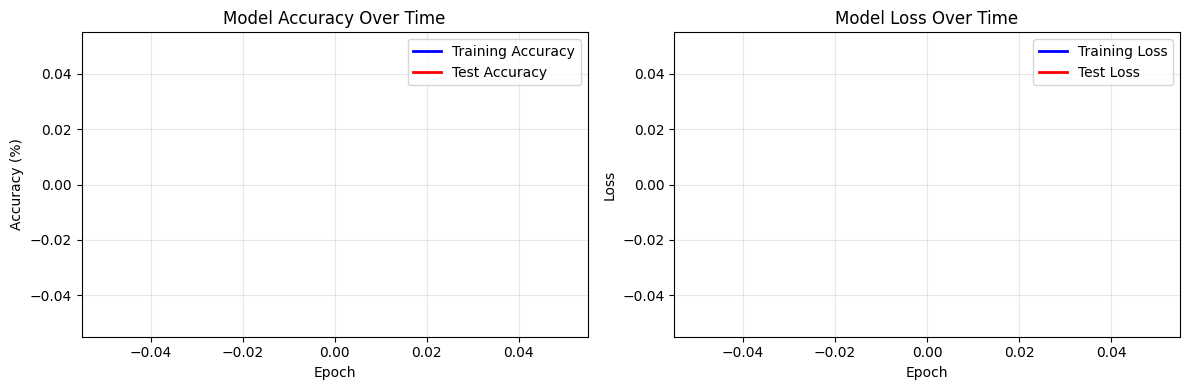

✓ Training curves displayed


In [7]:
print("Creating training history visualizations...")

# Create plots to visualize how the model learned over time
plt.figure(figsize=(12, 4))

# ACCURACY PLOT
plt.subplot(1, 2, 1)
plt.plot(train_accs, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(test_accs, 'r-', label='Test Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# What to look for:
# - Both curves should generally increase over time
# - Test accuracy should be close to training accuracy
# - If training accuracy >> test accuracy, the model is overfitting

# LOSS PLOT
plt.subplot(1, 2, 2)
plt.plot(train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(test_losses, 'r-', label='Test Loss', linewidth=2)
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# What to look for:
# - Both curves should generally decrease over time
# - Loss measures how "wrong" the model's predictions are
# - Lower loss = better performance

plt.tight_layout()
plt.show()

print("✓ Training curves displayed")

#Section 8 - Getting Results on Testing Dataset

In [14]:
# ==============================================================================
# SECTION 8: COMPREHENSIVE TESTING AND ANALYSIS
# ==============================================================================

print("Performing comprehensive model evaluation...")

# COLLECT ALL PREDICTIONS FOR DETAILED ANALYSIS
model.eval()                  # Set to evaluation mode
all_predictions = []          # Store all predicted classes
all_labels = []              # Store all true classes
all_probabilities = []       # Store prediction probabilities

print("Collecting predictions on entire test set...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)

        # Get probabilities using softmax
        probabilities = F.softmax(outputs, dim=1)  # Convert raw scores to probabilities

        # Get predicted classes (highest probability)
        _, predicted = torch.max(outputs, 1)

        # Store results (move back to CPU for analysis)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

# Convert to numpy arrays for easier analysis
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

print("==== Test Accuracy ====", np.sum(all_labels == all_predictions)/len(all_predictions))

Performing comprehensive model evaluation...
Accuracy 0.4185
✓ Collected predictions for 10000 test samples


#Section 9 - Confusion Matrix Analysis

Creating confusion matrix...


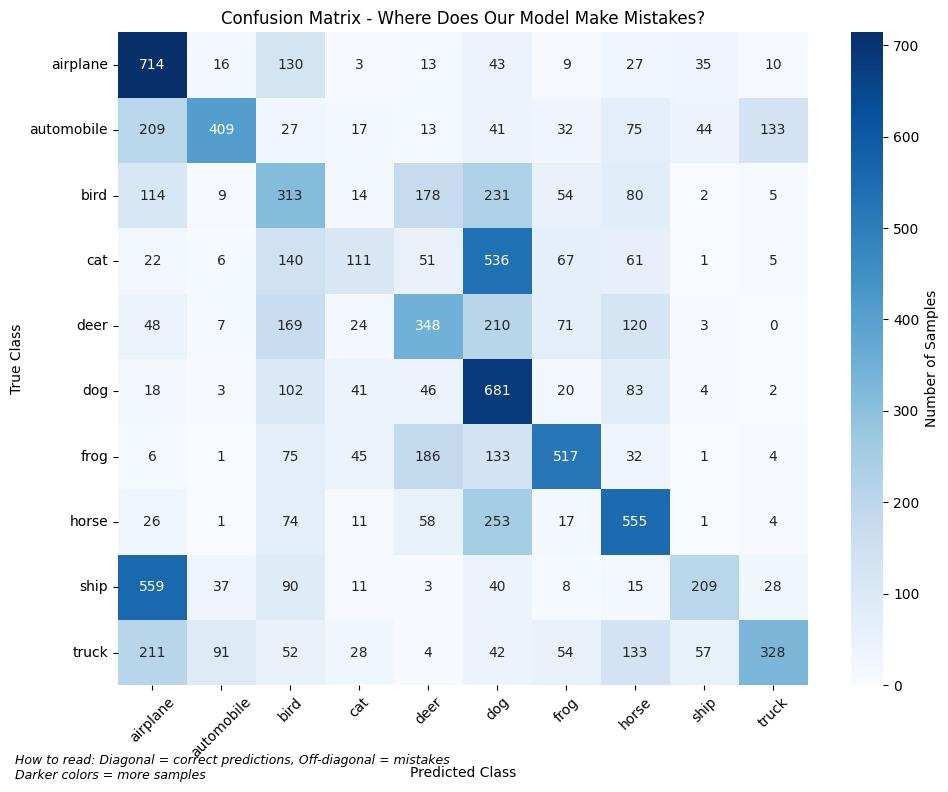

In [10]:
# ==============================================================================
# SECTION 9: CONFUSION MATRIX ANALYSIS
# ==============================================================================

print("Creating confusion matrix...")

# CONFUSION MATRIX
# Shows which classes the model confuses with each other
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix - Where Does Our Model Make Mistakes?')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Add explanation text
plt.figtext(0.02, 0.02,
    'How to read: Diagonal = correct predictions, Off-diagonal = mistakes\n'
    'Darker colors = more samples',
    fontsize=9, style='italic')

plt.tight_layout()
plt.show()